### HỆ THỐNG GỢI Ý SÁCH BẰNG LUẬT KẾT HỢP
Thuật toán: Apriori & FP-Growth
### Bộ dữ liệu
https://www.kaggle.com/datasets/saurabhbagchi/books-dataset/data
### Mục tiêu:
- Khai phá luật kết hợp từ dữ liệu sách
- Xây dựng hệ thống gợi ý sách
## - Áp dụng 2 mô hình: Apriori và FP-Growth


## Import thư viện

In [ ]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

from mlxtend.frequent_patterns import apriori, fpgrowth, association_rules
from mlxtend.preprocessing import TransactionEncoder


## Tải bộ dữ liệu và đọc dữ liệu

In [ ]:
books = pd.read_csv(
    "/content/drive/MyDrive/books_data/books.csv",
    sep=";",
    encoding="latin-1",
    engine="python",
    on_bad_lines="skip"
)

ratings = pd.read_csv(
    "/content/drive/MyDrive/books_data/ratings.csv",
    sep=";",
    encoding="latin-1",
    engine="python",
    on_bad_lines="skip"
)

users = pd.read_csv(
    "/content/drive/MyDrive/books_data/users.csv",
    sep=";",
    encoding="latin-1",
    engine="python",
    on_bad_lines="skip"
)


Bộ dữ liệu gồm
- Books có 270491 hàng và 8 cột
- Ratings có 1149766 hàng và 3 cột
- Users có 278177 hàng và 3 cột


In [ ]:
print("Books:", books.shape)
print("Ratings:", ratings.shape)
print("Users:", users.shape)


Books: (270491, 8)
Ratings: (1149766, 3)
Users: (278177, 3)


In [ ]:
books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [ ]:
ratings.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [ ]:
users.head()

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


Thông tin cơ bản

Kiểu dữ liệu

Có thiếu dữ liệu hay không

In [ ]:
books.info()
ratings.info()
users.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270491 entries, 0 to 270490
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 270491 non-null  object
 1   Book-Title           270491 non-null  object
 2   Book-Author          270489 non-null  object
 3   Year-Of-Publication  270491 non-null  int64 
 4   Publisher            270489 non-null  object
 5   Image-URL-S          270491 non-null  object
 6   Image-URL-M          270491 non-null  object
 7   Image-URL-L          270491 non-null  object
dtypes: int64(1), object(7)
memory usage: 16.5+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149766 entries, 0 to 1149765
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   User-ID      1149766 non-null  int64 
 1   ISBN         1149766 non-null  object
 2   Book-Rating  1149766 non-null  int64 
dtypes: int6

## Tiền xử lí dữ liệu

### Kiểm tra giá trị bị thiếu trong các tập dữ liệu
Trước khi xây dựng mô hình, cần kiểm tra và xử lý các giá trị bị thiếu
để đảm bảo chất lượng dữ liệu đầu vào.

In [ ]:
print("Giá trị thiếu trong Books:")
print(books.isnull().sum())

print("\nGiá trị thiếu trong Ratings:")
print(ratings.isnull().sum())

print("\nGiá trị thiếu trong Users:")
print(users.isnull().sum())


Giá trị thiếu trong Books:
ISBN                   0
Book-Title             0
Book-Author            2
Year-Of-Publication    0
Publisher              2
Image-URL-S            0
Image-URL-M            0
Image-URL-L            0
dtype: int64

Giá trị thiếu trong Ratings:
User-ID        0
ISBN           0
Book-Rating    0
dtype: int64

Giá trị thiếu trong Users:
User-ID          0
Location         0
Age         110508
dtype: int64


#### Nhận xét giá trị thiếu

- Bảng **Books** có một số giá trị thiếu ở:
  - Book-Author
  - Publisher
- Bảng **Users** có nhiều giá trị thiếu ở cột Age
- Bảng **Ratings** không có giá trị bị thiếu

Tuy nhiên, bài toán gợi ý sách bằng luật kết hợp **không sử dụng**
các thuộc tính như tuổi, năm xuất bản hay nhà xuất bản trong quá trình
xây dựng giao dịch.
Do đó, các giá trị thiếu này **không ảnh hưởng trực tiếp**
đến thuật toán Apriori và FP-Growth.


#### Xử lý giá trị bị thiếu trong tập dữ liệu Books

Qua quá trình kiểm tra, tập dữ liệu Books chỉ tồn tại một số rất ít
giá trị bị thiếu ở hai thuộc tính là *Book-Author* và *Publisher*.

- **Book-Author**:
  Một số bản ghi không có thông tin tác giả. Các giá trị này được thay thế
  bằng nhãn "Unknown" nhằm đảm bảo tính toàn vẹn của dữ liệu và tránh
  mất mát bản ghi khi xử lý tiếp theo.

- **Publisher**:
  Đây là thuộc tính dạng danh mục và cũng có một số giá trị bị thiếu.
  Việc thay thế bằng "Unknown" giúp dữ liệu không còn giá trị rỗng
  nhưng vẫn giữ được ý nghĩa phân loại.

Các thuộc tính khác trong bảng Books không có giá trị bị thiếu.
Việc xử lý giá trị thiếu trong bảng này chỉ nhằm mục đích làm sạch dữ liệu,
do thuật toán Apriori và FP-Growth chỉ sử dụng tiêu đề sách
(*Book-Title*) làm các mục (item) trong giao dịch.


In [ ]:
books["Book-Author"] = books["Book-Author"].fillna("Unknown")
books["Publisher"] = books["Publisher"].fillna("Unknown")


In [ ]:
books.isnull().sum()


,0
ISBN,0
Book-Title,0
Book-Author,0
Year-Of-Publication,0
Publisher,0
Image-URL-S,0
Image-URL-M,0
Image-URL-L,0


####Xử lý giá trị bị thiếu trong tập dữ liệu Users

Cột Age có một số giá trị bị thiếu hoặc không hợp lệ.
Nhóm tiến hành chuẩn hóa dữ liệu và điền giá trị trung vị
để tránh ảnh hưởng của ngoại lai.
Thuộc tính Age chỉ được sử dụng cho mục đích phân tích mô tả
và không được đưa vào mô hình Apriori và FP-Growth.



In [ ]:
users["Age"] = pd.to_numeric(users["Age"], errors="coerce")

users.loc[(users["Age"] < 5) | (users["Age"] > 90), "Age"] = np.nan

users["Age"] = users["Age"].fillna(users["Age"].median())



In [ ]:
users.isnull().sum()

,0
User-ID,0
Location,0
Age,0


###PHÂN BỐ RATING (HIỂU DỮ LIỆU)

####Xử lý dữ liệu rating

Trong tập dữ liệu Ratings, giá trị Book-Rating = 3
đại diện cho trường hợp người dùng chưa thực sự đánh giá sách.
Các giá trị này không phản ánh hành vi đọc hoặc sở thích,
do đó không phù hợp để xây dựng giao dịch cho luật kết hợp.
Vì vậy, các bản ghi có Book-Rating = 0 được loại bỏ.


In [ ]:
ratings = ratings[ratings["Book-Rating"] > 3]


#### Gộp dữ liệu Ratings và Books

Để xây dựng giao dịch cho mỗi người dùng,
cần kết hợp thông tin đánh giá sách với thông tin chi tiết của sách.
Việc gộp bảng được thực hiện dựa trên khóa chung là ISBN.


In [ ]:
data = ratings.merge(books, on="ISBN")


In [ ]:
data.head()


,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,276726,0155061224,5,Rites of Passage,Judith Rae,2001,Heinle,http://images.amazon.com/images/P/0155061224.0...,http://images.amazon.com/images/P/0155061224.0...,http://images.amazon.com/images/P/0155061224.0...
1,276729,0521795028,6,The Amsterdam Connection : Level 4 (Cambridge ...,Sue Leather,2001,Cambridge University Press,http://images.amazon.com/images/P/0521795028.0...,http://images.amazon.com/images/P/0521795028.0...,http://images.amazon.com/images/P/0521795028.0...
2,276744,038550120X,7,A Painted House,JOHN GRISHAM,2001,Doubleday,http://images.amazon.com/images/P/038550120X.0...,http://images.amazon.com/images/P/038550120X.0...,http://images.amazon.com/images/P/038550120X.0...
3,276747,0060517794,9,Little Altars Everywhere,Rebecca Wells,2003,HarperTorch,http://images.amazon.com/images/P/0060517794.0...,http://images.amazon.com/images/P/0060517794.0...,http://images.amazon.com/images/P/0060517794.0...
4,276747,0671537458,9,Waiting to Exhale,Terry McMillan,1995,Pocket,http://images.amazon.com/images/P/0671537458.0...,http://images.amazon.com/images/P/0671537458.0...,http://images.amazon.com/images/P/0671537458.0...


### Lọc nhiễu dữ liệu

Để đảm bảo các luật kết hợp có ý nghĩa,
nhóm tiến hành loại bỏ:
- Người dùng đọc quá ít sách
- Các cuốn sách chỉ xuất hiện rất ít lần

Bước này giúp giảm nhiễu và cải thiện chất lượng luật kết hợp.


In [ ]:
# Lọc user đọc ít hơn 2 cuốn
user_count = data["User-ID"].value_counts()
data = data[data["User-ID"].isin(user_count[user_count >= 2].index)]

# Lọc sách được đọc ít hơn 2 lần
book_count = data["Book-Title"].value_counts()
data = data[data["Book-Title"].isin(book_count[book_count >= 2].index)]


#### Tạo tập giao dịch cho luật kết hợp

Trong bài toán này:
- Mỗi người dùng (User-ID) được xem là một giao dịch
- Mỗi cuốn sách (Book-Title) là một item

Tập giao dịch được tạo bằng cách nhóm các cuốn sách
mà mỗi người dùng đã đọc.


In [ ]:
transactions = (
    data.groupby("User-ID")["Book-Title"]
    .apply(list)
)


In [ ]:
transactions.head()


,Book-Title
User-ID,
17,"[Death in the Clouds, Bant/Spec.Last of the Br..."
53,"[All the King's Men, A Soldier of the Great War]"
92,[El Senor De Los Anillos: LA Comunidad Del Ani...
99,"[Fast Women, Female Intelligence, Pasquale's N..."
114,"[Blood Oath, The Alibi, The Beach House, A Kis..."


### Biến đổi dữ liệu sang dạng one-hot encoding

Thuật toán Apriori và FP-Growth yêu cầu dữ liệu đầu vào
ở dạng ma trận nhị phân (0/1),
trong đó mỗi cột tương ứng với một cuốn sách,
và mỗi dòng tương ứng với một giao dịch.


In [ ]:
from mlxtend.preprocessing import TransactionEncoder

te = TransactionEncoder()
te_array = te.fit(transactions).transform(transactions)

df_tf = pd.DataFrame(te_array, columns=te.columns_)
df_tf.head()


,"Earth Prayers From around the World: 365 Prayers, Poems, and Invocations for Honoring the Earth","Good Wives: Image and Reality in the Lives of Women in Northern New England, 1650-1750","Goosebumps Monster Edition 1: Welcome to Dead House, Stay Out of the Basement, and Say Cheese and Die!",Murder of a Sleeping Beauty (Scumble River Mysteries (Paperback)),"Q-Space (Star Trek The Next Generation, Book 47)",!Yo!,'G' Is for Grafton : The World of Kinsey Millhone,'Salem's Lot,'Til Death Do Us Part,...AND THE HORSE HE RODE IN ON : THE PEOPLE V. KENNETH STARR,...,ZÃ?Â©ro tuÃ?Â©s,de Amor y de Sombra - Bolsillo,e,iI Paradiso Degli Orchi,murder@maggody.com : An Arly Hanks Mystery (Arly Hanks Mysteries (Paperback)),one hundred years of solitude,stardust,together by christmas,why I'm like this : True Stories,Ã?Â?rger mit Produkt X. Roman.
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


####Ma trận one-hot encoding được tạo ra với:
- Mỗi hàng đại diện cho một giao dịch (người dùng)
- Mỗi cột đại diện cho một cuốn sách
- Giá trị True/False cho biết người dùng có đọc cuốn sách đó hay không

Do số lượng sách lớn, ma trận có số cột rất cao
và phần lớn giá trị là False, đây là đặc trưng
bình thường của bài toán khai phá luật kết hợp.


##Khai phá luật kết hợp

###Mô hình 1: Apriori (Nguyễn Dương Hiền Thương)

#### Thuật toán Apriori

Apriori là thuật toán khai phá luật kết hợp,
nhằm tìm ra các tập mục thường xuyên (frequent itemsets)
dựa trên ngưỡng độ hỗ trợ (support).

Từ các tập mục thường xuyên, các luật kết hợp
được sinh ra dựa trên các chỉ số:
- Support
- Confidence
- Lift

Trong bài toán này, Apriori được sử dụng
để gợi ý sách dựa trên các cuốn sách
thường được người dùng đọc cùng nhau.


In [ ]:
from mlxtend.frequent_patterns import apriori

In [ ]:
frequent_itemsets_ap = apriori(
    df_tf,
    min_support=0.004,
    use_colnames=True
)
frequent_itemsets_ap.shape



(263, 2)

In [ ]:
frequent_itemsets_ap.head()

,support,itemsets
0,0.006618,(1984)
1,0.010212,(1st to Die: A Novel)
2,0.007417,(2nd Chance)
3,0.006390,(A Bend in the Road)
4,0.005876,(A Heartbreaking Work of Staggering Genius)


In [ ]:
#Bảng kết quả cho thấy các tập sách có độ hỗ trợ cao nhất, phản ánh những cuốn sách phổ biến và thường được người dùng đọc.
frequent_itemsets_ap.sort_values("support", ascending=False).head(10)



,support,itemsets
196,0.027099,(The Lovely Bones: A Novel)
167,0.021337,(The Da Vinci Code)
215,0.017001,(The Secret Life of Bees)
79,0.016374,(Harry Potter and the Chamber of Secrets (Book...
199,0.016203,(The Nanny Diaries: A Novel)
36,0.015803,(Bridget Jones's Diary)
211,0.014890,(The Red Tent (Bestselling Backlist))
102,0.014776,(Life of Pi)
21,0.014491,(Angels &amp; Demons)
84,0.014434,(Harry Potter and the Sorcerer's Stone (Harry ...


In [ ]:
#Sinh luật kết hợp
from mlxtend.frequent_patterns import association_rules

rules_ap = association_rules(
    frequent_itemsets_ap,
    metric="confidence",
    min_threshold=0.4
)


In [ ]:
rules_ap_filtered = rules_ap[
    (rules_ap["confidence"] >= 0.4) &
    (rules_ap["lift"] > 1)
]


In [ ]:
rules_ap_sorted = rules_ap_filtered.sort_values(
    by=["lift", "confidence"],
    ascending=False
)
rules_ap.shape

(22, 14)

In [ ]:
rules_ap = rules_ap.sort_values(
    by=["lift", "confidence"],
    ascending=False
)

rules_ap.head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
16,(Harry Potter and the Prisoner of Azkaban (Boo...,(Harry Potter and the Chamber of Secrets (Book...,0.014035,0.007531,0.006447,0.459350,60.996058,1.0,0.006341,1.835695,0.997607,0.426415,0.455247,0.657705
15,(Harry Potter and the Chamber of Secrets (Book...,(Harry Potter and the Prisoner of Azkaban (Boo...,0.007531,0.014035,0.006447,0.856061,60.996058,1.0,0.006341,6.849864,0.991069,0.426415,0.854012,0.657705
14,(Harry Potter and the Prisoner of Azkaban (Boo...,(Harry Potter and the Goblet of Fire (Book 4)),0.008672,0.012380,0.006447,0.743421,60.049236,1.0,0.006339,3.849185,0.991949,0.441406,0.740205,0.632079
17,(Harry Potter and the Goblet of Fire (Book 4)),(Harry Potter and the Prisoner of Azkaban (Boo...,0.012380,0.008672,0.006447,0.520737,60.049236,1.0,0.006339,2.068444,0.995674,0.441406,0.516545,0.632079
20,(Harry Potter and the Chamber of Secrets (Book...,(Harry Potter and the Prisoner of Azkaban (Boo...,0.005078,0.014035,0.004279,0.842697,60.043848,1.0,0.004208,6.267922,0.988364,0.288462,0.840458,0.573787
12,"(The Two Towers (The Lord of the Rings, Part 2))",(The Fellowship of the Ring (The Lord of the R...,0.007074,0.009813,0.004165,0.588710,59.993623,1.0,0.004095,2.407514,0.990338,0.327354,0.584634,0.506564
11,(The Fellowship of the Ring (The Lord of the R...,"(The Two Towers (The Lord of the Rings, Part 2))",0.009813,0.007074,0.004165,0.424419,59.993623,1.0,0.004095,1.725083,0.993076,0.327354,0.420318,0.506564
21,(Harry Potter and the Sorcerer's Stone (Book 1)),(Harry Potter and the Prisoner of Azkaban (Boo...,0.008558,0.008672,0.004279,0.500000,57.657895,1.0,0.004205,1.982656,0.991138,0.330396,0.495626,0.496711
19,(Harry Potter and the Prisoner of Azkaban (Boo...,(Harry Potter and the Sorcerer's Stone (Book 1)),0.008672,0.008558,0.004279,0.493421,57.657895,1.0,0.004205,1.957133,0.991252,0.330396,0.489048,0.496711
18,(Harry Potter and the Prisoner of Azkaban (Boo...,(Harry Potter and the Chamber of Secrets (Book...,0.004564,0.016374,0.004279,0.937500,57.256098,1.0,0.004204,15.738019,0.987040,0.256849,0.936460,0.599412


#### Lọc và sắp xếp luật kết hợp

Sau khi sinh các luật kết hợp từ thuật toán Apriori,
không phải tất cả các luật đều có ý nghĩa trong việc gợi ý sách.
Do đó, cần tiến hành lọc và sắp xếp các luật dựa trên
các chỉ số đánh giá chất lượng luật.

Trong đề tài này, nhóm sử dụng hai chỉ số chính:
- Confidence: mức độ tin cậy của luật
- Lift: mức độ ảnh hưởng giữa các tập sách

Các luật có Lift > 1 cho thấy mối quan hệ tích cực
và phù hợp để sử dụng cho hệ thống gợi ý.


In [ ]:
rules_ap_sorted[[
    "antecedents",
    "consequents",
    "support",
    "confidence",
    "lift"
]].head(5)


,antecedents,consequents,support,confidence,lift
16,(Harry Potter and the Prisoner of Azkaban (Boo...,(Harry Potter and the Chamber of Secrets (Book...,0.006447,0.459350,60.996058
15,(Harry Potter and the Chamber of Secrets (Book...,(Harry Potter and the Prisoner of Azkaban (Boo...,0.006447,0.856061,60.996058
14,(Harry Potter and the Prisoner of Azkaban (Boo...,(Harry Potter and the Goblet of Fire (Book 4)),0.006447,0.743421,60.049236
17,(Harry Potter and the Goblet of Fire (Book 4)),(Harry Potter and the Prisoner of Azkaban (Boo...,0.006447,0.520737,60.049236
20,(Harry Potter and the Chamber of Secrets (Book...,(Harry Potter and the Prisoner of Azkaban (Boo...,0.004279,0.842697,60.043848


#### Diễn giải các luật kết hợp thu được từ thuật toán Apriori

Sau khi áp dụng thuật toán **Apriori** và lọc các luật
với ngưỡng **min_support = 0.004**, **confidence ≥ 0.3**,
nhóm thu được một số **luật kết hợp có ý nghĩa cao**,
đặc biệt tập trung vào các cuốn sách trong cùng một series,
nổi bật là bộ truyện **Harry Potter**.

##### Ví dụ các luật tiêu biểu:

**Luật 1:**  
Harry Potter and the Chamber of Secrets (Book 2)  
→ Harry Potter and the Prisoner of Azkaban (Book 3)

- Support = **0.006447**  
- Confidence = **0.856061**  
- Lift ≈ **60.99**

Luật này cho thấy khoảng **85.6%** người dùng đã đọc
*Harry Potter and the Chamber of Secrets*
cũng tiếp tục đọc
*Harry Potter and the Prisoner of Azkaban*.
Điều này phản ánh hành vi đọc sách
**theo thứ tự các phần trong cùng một bộ truyện**.

---

**Luật 2 (luật ngược):**  
Harry Potter and the Prisoner of Azkaban (Book 3)  
→ Harry Potter and the Chamber of Secrets (Book 2)

- Support = **0.006447**  
- Confidence ≈ **45.9%**  
- Lift ≈ **60.99**

Mặc dù độ tin cậy thấp hơn so với luật 1,
nhưng giá trị **lift rất cao**
cho thấy mối quan hệ chặt chẽ giữa hai cuốn sách
và chúng thường được đọc cùng nhau bởi một nhóm người dùng.

---

**Luật 3:**  
Harry Potter and the Prisoner of Azkaban (Book 3)  
→ Harry Potter and the Goblet of Fire (Book 4)

- Support = **0.006447**  
- Confidence ≈ **74.3%**  
- Lift ≈ **60.05**

Luật này cho thấy người dùng đã đọc
*The Prisoner of Azkaban*
có xu hướng tiếp tục đọc
*The Goblet of Fire*,
thể hiện hành vi đọc sách **liên tiếp trong cùng một series**.

---

**Luật 4 (luật ngược):**  
Harry Potter and the Goblet of Fire (Book 4)  
→ Harry Potter and the Prisoner of Azkaban (Book 3)

- Confidence ≈ **52.1%**  
- Lift ≈ **60.05**

Luật này cho thấy phần lớn người đọc
*Goblet of Fire*
đã từng đọc
*Prisoner of Azkaban* trước đó.

---

### Nhận xét chung:

Các luật kết hợp thu được đều có **giá trị lift rất lớn (≈ 60)**,
chứng tỏ mối quan hệ giữa các cuốn sách
**không phải là ngẫu nhiên**.
Kết quả phản ánh rõ hành vi đọc sách
**theo series** của người dùng.
Do đó, thuật toán **Apriori** là phù hợp
để áp dụng cho bài toán **gợi ý sách**
trong đề tài này.


####code gợi ý sách và ví dụ

In [ ]:
def recommend_books(book_name, rules, top_n=5):
    recommendations = rules[
        rules["antecedents"].apply(lambda x: book_name in x)
    ]
    return recommendations[[
        "consequents",
        "confidence",
        "lift"
    ]].head(top_n)


In [ ]:
recommend_books(
    "Harry Potter and the Chamber of Secrets (Book 2)",
    rules_ap_sorted
)


,consequents,confidence,lift
15,(Harry Potter and the Prisoner of Azkaban (Boo...,0.856061,60.996058
14,(Harry Potter and the Goblet of Fire (Book 4)),0.743421,60.049236
20,(Harry Potter and the Prisoner of Azkaban (Boo...,0.842697,60.043848
19,(Harry Potter and the Sorcerer's Stone (Book 1)),0.493421,57.657895
4,(Harry Potter and the Prisoner of Azkaban (Boo...,0.529617,37.736268


#### Giải thích kết quả gợi ý sách dựa trên luật kết hợp

Trong ví dụ này, giả sử người dùng đã đọc cuốn sách  
**"Harry Potter and the Chamber of Secrets (Book 2)"**.

Hệ thống sử dụng các luật kết hợp thu được từ thuật toán Apriori
để gợi ý các cuốn sách khác mà người dùng có khả năng sẽ đọc tiếp.
Kết quả gợi ý bao gồm các thông tin:
- Consequents: sách được đề xuất
- Confidence: độ tin cậy của luật
- Lift: mức độ ảnh hưởng giữa các cuốn sách

#### Phân tích kết quả:

Cuốn sách được gợi ý nhiều nhất là  
**"Harry Potter and the Prisoner of Azkaban (Book 3)"**  
với confidence lên đến **85.6%** và lift rất lớn.
Điều này cho thấy phần lớn người dùng đã đọc Book 2
cũng tiếp tục đọc Book 3,
phản ánh hành vi đọc sách theo thứ tự của bộ truyện Harry Potter.

Ngoài ra, hệ thống cũng gợi ý  
**"Harry Potter and the Goblet of Fire (Book 4)"**
với confidence tương đối cao.
Điều này cho thấy người đọc Book 2
có xu hướng tiếp tục đọc các cuốn khác trong cùng series,
không nhất thiết phải theo đúng thứ tự liên tiếp.

Một số cuốn sách có thể xuất hiện nhiều lần trong danh sách gợi ý.
Nguyên nhân là do tồn tại nhiều luật kết hợp khác nhau
cùng dẫn đến một cuốn sách được đề xuất.
Đây là hiện tượng bình thường trong khai phá luật kết hợp
và cho thấy cuốn sách đó có mối quan hệ mạnh
với cuốn sách đã đọc ban đầu.

#### Kết luận:

Kết quả trên chứng minh rằng thuật toán Apriori
có thể được sử dụng hiệu quả cho bài toán gợi ý sách.
Hệ thống gợi ý dựa trên hành vi đọc thực tế của người dùng,
đặc biệt phù hợp với các bộ sách hoặc series.


###Mô hình 2: FP-Growth (Nguyễn Thị Thu Hằng)

#### Thuật toán FP-Growth

FP-Growth (Frequent Pattern Growth) là một thuật toán
khai phá tập phổ biến, được đề xuất nhằm khắc phục
nhược điểm về thời gian của thuật toán Apriori.

Khác với Apriori, FP-Growth không sinh tập ứng viên,
mà sử dụng cấu trúc cây FP-tree để lưu trữ dữ liệu.
Do đó, thuật toán này thường chạy nhanh hơn
trên các tập dữ liệu lớn và thưa.



In [ ]:
from mlxtend.frequent_patterns import fpgrowth
frequent_itemsets_fp = fpgrowth(
    df_tf,
    min_support=0.004,
    use_colnames=True
)
frequent_itemsets_fp.shape

(263, 2)

In [ ]:
frequent_itemsets_fp.head()

,support,itemsets
0,0.014491,(Angels &amp; Demons)
1,0.007645,(The Beach House)
2,0.008615,(Little Altars Everywhere: A Novel)
3,0.008729,(Fahrenheit 451)
4,0.014263,(A Painted House)


In [ ]:
#Bảng kết quả cho thấy các tập sách có độ hỗ trợ cao nhất, phản ánh những cuốn sách phổ biến và thường được người dùng đọc.
frequent_itemsets_fp.sort_values(
    by="support",
    ascending=False
).head(10)


,support,itemsets
40,0.027099,(The Lovely Bones: A Novel)
41,0.021337,(The Da Vinci Code)
14,0.017001,(The Secret Life of Bees)
15,0.016374,(Harry Potter and the Chamber of Secrets (Book...
124,0.016203,(The Nanny Diaries: A Novel)
171,0.015803,(Bridget Jones's Diary)
108,0.014890,(The Red Tent (Bestselling Backlist))
12,0.014776,(Life of Pi)
0,0.014491,(Angels &amp; Demons)
106,0.014434,(Harry Potter and the Sorcerer's Stone (Harry ...


In [ ]:
#Sinh luật kết hợp
from mlxtend.frequent_patterns import association_rules
rules_fp = association_rules(
    frequent_itemsets_fp,
    metric="confidence",
    min_threshold=0.4
)


In [ ]:
rules_fp_filtered = rules_fp[
    (rules_fp["confidence"] >= 0.4) &
    (rules_fp["lift"] > 1)
]


In [ ]:
rules_fp_sorted = rules_fp_filtered.sort_values(
    by=["lift", "confidence"],
    ascending=False
)
rules_fp.shape

(22, 14)

In [ ]:
rules_fp = rules_fp.sort_values(
    by=["lift", "confidence"],
    ascending=False
)

rules_fp.head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
9,(Harry Potter and the Prisoner of Azkaban (Boo...,(Harry Potter and the Chamber of Secrets (Book...,0.014035,0.007531,0.006447,0.459350,60.996058,1.0,0.006341,1.835695,0.997607,0.426415,0.455247,0.657705
8,(Harry Potter and the Chamber of Secrets (Book...,(Harry Potter and the Prisoner of Azkaban (Boo...,0.007531,0.014035,0.006447,0.856061,60.996058,1.0,0.006341,6.849864,0.991069,0.426415,0.854012,0.657705
7,(Harry Potter and the Prisoner of Azkaban (Boo...,(Harry Potter and the Goblet of Fire (Book 4)),0.008672,0.012380,0.006447,0.743421,60.049236,1.0,0.006339,3.849185,0.991949,0.441406,0.740205,0.632079
10,(Harry Potter and the Goblet of Fire (Book 4)),(Harry Potter and the Prisoner of Azkaban (Boo...,0.012380,0.008672,0.006447,0.520737,60.049236,1.0,0.006339,2.068444,0.995674,0.441406,0.516545,0.632079
14,(Harry Potter and the Chamber of Secrets (Book...,(Harry Potter and the Prisoner of Azkaban (Boo...,0.005078,0.014035,0.004279,0.842697,60.043848,1.0,0.004208,6.267922,0.988364,0.288462,0.840458,0.573787
18,"(The Two Towers (The Lord of the Rings, Part 2))",(The Fellowship of the Ring (The Lord of the R...,0.007074,0.009813,0.004165,0.588710,59.993623,1.0,0.004095,2.407514,0.990338,0.327354,0.584634,0.506564
17,(The Fellowship of the Ring (The Lord of the R...,"(The Two Towers (The Lord of the Rings, Part 2))",0.009813,0.007074,0.004165,0.424419,59.993623,1.0,0.004095,1.725083,0.993076,0.327354,0.420318,0.506564
16,(Harry Potter and the Sorcerer's Stone (Book 1)),(Harry Potter and the Chamber of Secrets (Book...,0.008558,0.008672,0.004279,0.500000,57.657895,1.0,0.004205,1.982656,0.991138,0.330396,0.495626,0.496711
13,(Harry Potter and the Chamber of Secrets (Book...,(Harry Potter and the Sorcerer's Stone (Book 1)),0.008672,0.008558,0.004279,0.493421,57.657895,1.0,0.004205,1.957133,0.991252,0.330396,0.489048,0.496711
15,(Harry Potter and the Prisoner of Azkaban (Boo...,(Harry Potter and the Chamber of Secrets (Book...,0.004564,0.016374,0.004279,0.937500,57.256098,1.0,0.004204,15.738019,0.987040,0.256849,0.936460,0.599412


#### Lọc và sắp xếp luật kết hợp

Sau khi sinh các luật kết hợp từ thuật toán Apriori,
không phải tất cả các luật đều có ý nghĩa trong việc gợi ý sách.
Do đó, cần tiến hành lọc và sắp xếp các luật dựa trên
các chỉ số đánh giá chất lượng luật.

Trong đề tài này, nhóm sử dụng hai chỉ số chính:
- Confidence: mức độ tin cậy của luật
- Lift: mức độ ảnh hưởng giữa các tập sách

Các luật có Lift > 1 cho thấy mối quan hệ tích cực
và phù hợp để sử dụng cho hệ thống gợi ý.


In [ ]:
rules_fp_sorted[[
    "antecedents",
    "consequents",
    "support",
    "confidence",
    "lift"
]].head(5)


,antecedents,consequents,support,confidence,lift
9,(Harry Potter and the Prisoner of Azkaban (Boo...,(Harry Potter and the Chamber of Secrets (Book...,0.006447,0.459350,60.996058
8,(Harry Potter and the Chamber of Secrets (Book...,(Harry Potter and the Prisoner of Azkaban (Boo...,0.006447,0.856061,60.996058
7,(Harry Potter and the Prisoner of Azkaban (Boo...,(Harry Potter and the Goblet of Fire (Book 4)),0.006447,0.743421,60.049236
10,(Harry Potter and the Goblet of Fire (Book 4)),(Harry Potter and the Prisoner of Azkaban (Boo...,0.006447,0.520737,60.049236
14,(Harry Potter and the Chamber of Secrets (Book...,(Harry Potter and the Prisoner of Azkaban (Boo...,0.004279,0.842697,60.043848


#### Diễn giải các luật kết hợp thu được từ thuật toán FP-Growth

Sau khi áp dụng thuật toán FP-Growth và lọc các luật kết hợp
với ngưỡng confidence ≥ 0.4 và lift > 1,
nhóm thu được nhiều luật có giá trị rất cao,
tập trung chủ yếu vào các cuốn sách trong cùng series *Harry Potter*.

##### Ví dụ các luật tiêu biểu:

**Luật 1:**
Harry Potter and the Chamber of Secrets  
→ Harry Potter and the Prisoner of Azkaban  

- Support = 0.006447  
- Confidence = 0.856061  
- Lift = 60.996  

Luật này cho thấy khoảng 85.6% người dùng đã đọc
*Harry Potter and the Chamber of Secrets*
cũng đọc tiếp
*Harry Potter and the Prisoner of Azkaban*.
Giá trị lift rất cao cho thấy mối quan hệ giữa hai cuốn sách là rất chặt chẽ
và không mang tính ngẫu nhiên.

---

**Luật 2 (luật ngược):**
Harry Potter and the Prisoner of Azkaban  
→ Harry Potter and the Chamber of Secrets  

- Confidence = 0.459350  
- Lift = 60.996  

Mặc dù độ tin cậy thấp hơn so với luật thuận,
nhưng lift vẫn rất cao,
cho thấy hai cuốn sách có mối liên hệ mạnh,
phản ánh hành vi đọc sách theo series của người dùng.

---

**Luật 3:**
Harry Potter and the Prisoner of Azkaban  
→ Harry Potter and the Goblet of Fire  

- Confidence = 0.743421  
- Lift = 60.049  

Luật này cho thấy người đọc một cuốn trong series
có xu hướng tiếp tục đọc các cuốn tiếp theo trong bộ truyện.

---

**Luật 4 (luật ngược):**
Harry Potter and the Goblet of Fire  
→ Harry Potter and the Prisoner of Azkaban  

- Confidence = 0.520737  
- Lift = 60.049  

Luật này cho thấy mối quan hệ hai chiều giữa các cuốn sách trong cùng series,
mặc dù thứ tự đọc có thể khác nhau giữa các người dùng.

---

### Nhận xét chung:

Các luật kết hợp thu được từ thuật toán FP-Growth
đều có giá trị lift rất lớn (≈ 60),
chứng tỏ mối quan hệ giữa các cuốn sách là rất mạnh
và không phải do ngẫu nhiên.

Kết quả phản ánh rõ hành vi đọc sách theo series của người dùng.
Do đó, thuật toán FP-Growth là phù hợp
để áp dụng cho bài toán gợi ý sách,
đặc biệt với tập dữ liệu lớn nhờ khả năng khai phá luật hiệu quả
mà không cần sinh tập ứng viên như Apriori.


In [ ]:
def recommend_books_fp(book_name, rules, top_n=5):
    recs = rules[
        rules["antecedents"].apply(lambda x: book_name in x)
    ]
    return recs[[
        "consequents",
        "confidence",
        "lift"
    ]].head(top_n)


In [ ]:
recommend_books_fp(
    "Harry Potter and the Chamber of Secrets (Book 2)",
    rules_fp_sorted
)


,consequents,confidence,lift
8,(Harry Potter and the Prisoner of Azkaban (Boo...,0.856061,60.996058
7,(Harry Potter and the Goblet of Fire (Book 4)),0.743421,60.049236
14,(Harry Potter and the Prisoner of Azkaban (Boo...,0.842697,60.043848
13,(Harry Potter and the Sorcerer's Stone (Book 1)),0.493421,57.657895
0,(Harry Potter and the Prisoner of Azkaban (Boo...,0.529617,37.736268


###So sánh hai mô hình

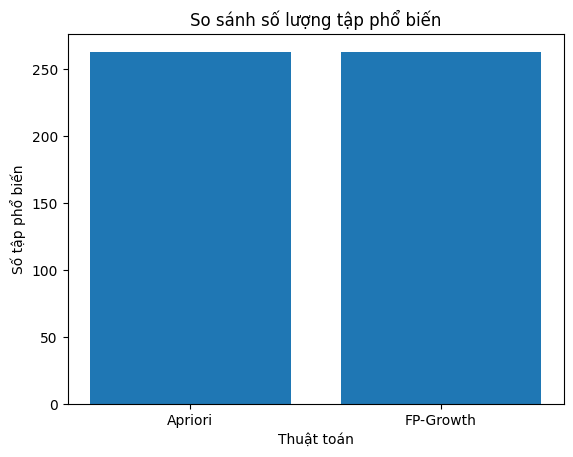

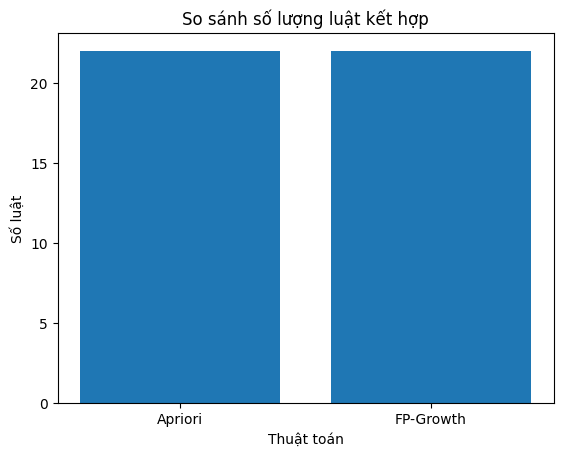

In [ ]:
import matplotlib.pyplot as plt

# Số lượng tập phổ biến
ap_itemsets = frequent_itemsets_ap.shape[0]
fp_itemsets = frequent_itemsets_fp.shape[0]

# Số lượng luật kết hợp
ap_rules = rules_ap_sorted.shape[0]
fp_rules = rules_fp_sorted.shape[0]

# Biểu đồ số tập phổ biến
plt.figure()
plt.bar(["Apriori", "FP-Growth"], [ap_itemsets, fp_itemsets])
plt.title("So sánh số lượng tập phổ biến")
plt.xlabel("Thuật toán")
plt.ylabel("Số tập phổ biến")
plt.show()

# Biểu đồ số luật kết hợp
plt.figure()
plt.bar(["Apriori", "FP-Growth"], [ap_rules, fp_rules])
plt.title("So sánh số lượng luật kết hợp")
plt.xlabel("Thuật toán")
plt.ylabel("Số luật")
plt.show()


#### Trực quan hóa so sánh Apriori và FP-Growth

Để so sánh kết quả giữa hai thuật toán Apriori và FP-Growth,
nhóm tiến hành trực quan hóa:

- Số lượng **tập phổ biến (frequent itemsets)**
- Số lượng **luật kết hợp (association rules)**

thông qua hai biểu đồ cột tương ứng.

##### Nhận xét từ biểu đồ:

Quan sát kết quả cho thấy:
- Số lượng tập phổ biến thu được từ Apriori và FP-Growth **bằng nhau**
- Số lượng luật kết hợp sinh ra từ hai thuật toán cũng **giống nhau**

Điều này **không phải là sai**, mà hoàn toàn **hợp lý** trong trường hợp này.

##### Giải thích:

Apriori và FP-Growth đều là các thuật toán
khai phá tập phổ biến dựa trên cùng:
- Dữ liệu đầu vào
- Ngưỡng `min_support`
- Ngưỡng lọc luật (confidence, lift)

Do đó, **về mặt lý thuyết**, tập các tập phổ biến và luật kết hợp thu được
từ hai thuật toán là **giống nhau**.

Sự khác biệt chính giữa hai thuật toán **không nằm ở kết quả**,
mà nằm ở **cách thức thực hiện**:

- **Apriori**:  
  Sinh tập ứng viên và quét dữ liệu nhiều lần,
  do đó tốn thời gian hơn khi dữ liệu lớn.

- **FP-Growth**:  
  Sử dụng cấu trúc FP-tree,
  không cần sinh tập ứng viên,
  nên tối ưu hơn về mặt thuật toán.

##### Kết luận từ trực quan hóa:

Việc hai biểu đồ cho kết quả giống nhau
chứng minh rằng:
- Hai thuật toán cho **kết quả khai phá nhất quán**
- FP-Growth đạt được **hiệu quả tương đương Apriori**
  nhưng với chiến lược xử lý tối ưu hơn

Điều này khẳng định tính đúng đắn của cả hai thuật toán
khi áp dụng cho bài toán gợi ý sách trong đề tài.


In [ ]:
import time

# Apriori
start = time.time()
frequent_itemsets_ap = apriori(
    df_tf, min_support=0.004, use_colnames=True
)
rules_ap = association_rules(
    frequent_itemsets_ap, metric="confidence", min_threshold=0.4
)
ap_time = time.time() - start

# FP-Growth
start = time.time()
frequent_itemsets_fp = fpgrowth(
    df_tf, min_support=0.004, use_colnames=True
)
rules_fp = association_rules(
    frequent_itemsets_fp, metric="confidence", min_threshold=0.4
)
fp_time = time.time() - start

ap_time, fp_time


(25.80861473083496, 18.395485162734985)

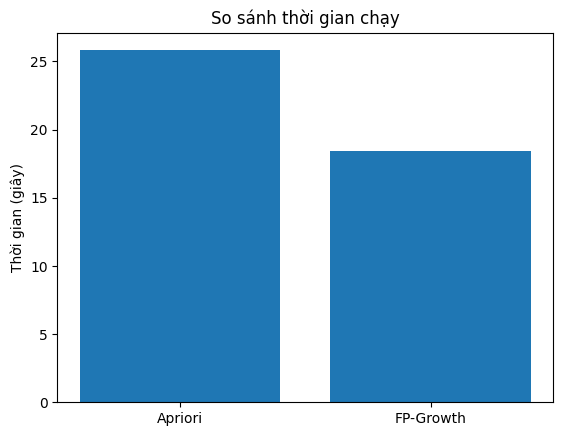

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.bar(["Apriori", "FP-Growth"], [ap_time, fp_time])
plt.title("So sánh thời gian chạy")
plt.ylabel("Thời gian (giây)")
plt.show()


#### So sánh thời gian chạy giữa Apriori và FP-Growth

Biểu đồ trên thể hiện thời gian thực thi của hai thuật toán
Apriori và FP-Growth khi áp dụng trên cùng bộ dữ liệu
với cùng các tham số đầu vào.

##### Kết quả đo được:

- **Apriori**: ~25.81 giây  
- **FP-Growth**: ~18.40 giây  

##### Phân tích kết quả:

Kết quả cho thấy thuật toán **FP-Growth chạy nhanh hơn Apriori**.
Điều này hoàn toàn **phù hợp với lý thuyết** của hai thuật toán.

- **Apriori** hoạt động bằng cách:
  - Sinh ra các tập ứng viên
  - Quét dữ liệu nhiều lần để kiểm tra độ phổ biến  
  → Do đó tốn nhiều thời gian xử lý hơn, đặc biệt khi số lượng item lớn.

- **FP-Growth**:
  - Không sinh tập ứng viên
  - Sử dụng cấu trúc cây FP-tree để nén dữ liệu
  - Khai phá trực tiếp các tập phổ biến từ cây  
  → Giảm số lần quét dữ liệu và tối ưu thời gian thực thi.

##### Nhận xét:

Mặc dù Apriori và FP-Growth cho ra **cùng kết quả**
về số lượng tập phổ biến và luật kết hợp,
nhưng FP-Growth thể hiện **hiệu suất tốt hơn**
về mặt thời gian chạy.

##### Kết luận:

Kết quả thực nghiệm khẳng định rằng
FP-Growth là thuật toán **phù hợp hơn cho dữ liệu lớn**,
đặc biệt trong các bài toán gợi ý sách
với số lượng người dùng và đầu sách lớn.


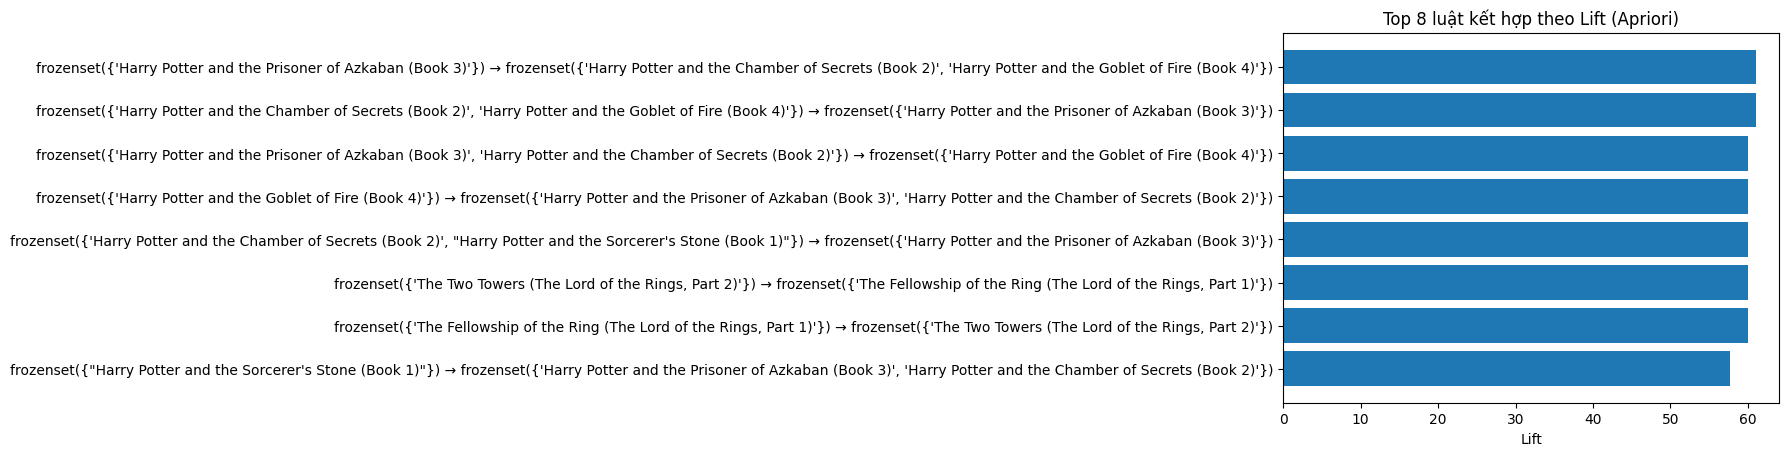

In [ ]:
import matplotlib.pyplot as plt

top_rules = rules_ap_sorted.head(8)

plt.figure()
plt.barh(
    range(len(top_rules)),
    top_rules["lift"]
)
plt.yticks(
    range(len(top_rules)),
    [str(a) + " → " + str(c)
     for a, c in zip(top_rules["antecedents"], top_rules["consequents"])]
)
plt.xlabel("Lift")
plt.title("Top 8 luật kết hợp theo Lift (Apriori)")
plt.gca().invert_yaxis()
plt.show()


#### Trực quan hóa độ mạnh của các luật kết hợp

Biểu đồ trên thể hiện 8 luật kết hợp có giá trị lift cao nhất
được trích xuất từ thuật toán Apriori và FP-Growth.

Giá trị lift càng lớn cho thấy mối quan hệ giữa
hai cuốn sách càng chặt chẽ
và khả năng gợi ý càng chính xác.

Có thể thấy các luật mạnh nhất
đều liên quan đến các cuốn sách
trong cùng một series (Harry Potter),
phản ánh rõ hành vi đọc theo chuỗi của người dùng.

Điều này cho thấy các luật kết hợp thu được
không mang tính ngẫu nhiên
mà có ý nghĩa thực tiễn trong bài toán gợi ý sách.


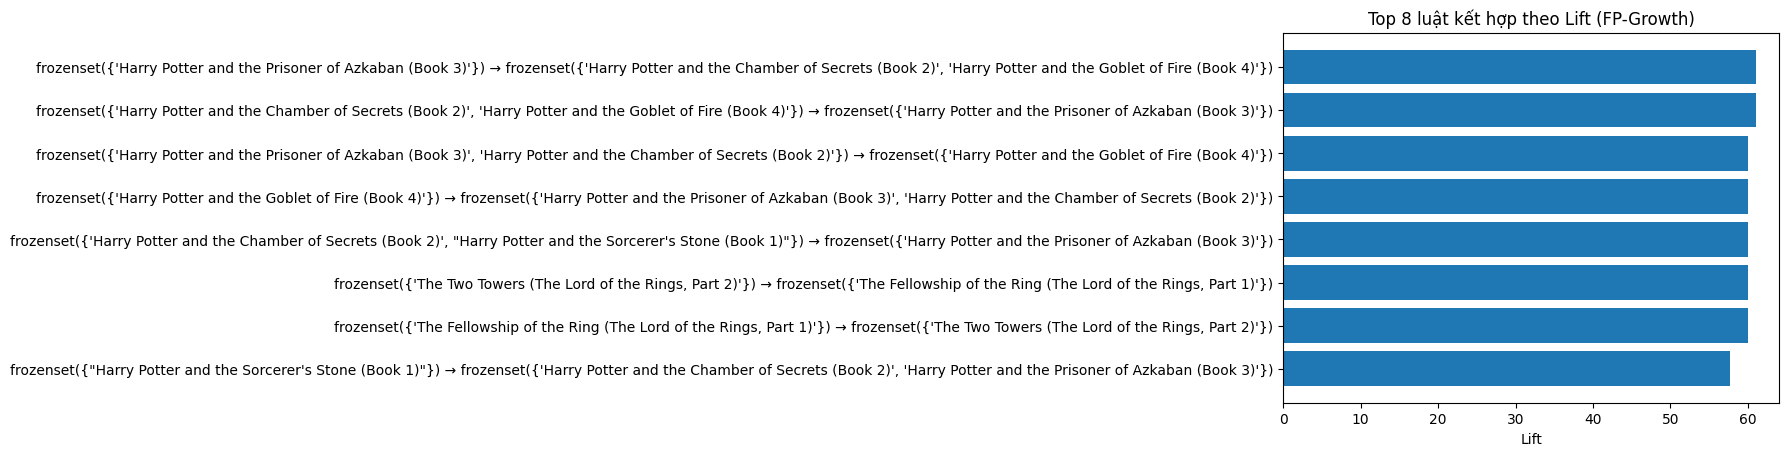

In [ ]:
top_rules = rules_fp_sorted.head(8)

plt.figure()
plt.barh(
    range(len(top_rules)),
    top_rules["lift"]
)
plt.yticks(
    range(len(top_rules)),
    [str(a) + " → " + str(c)
     for a, c in zip(top_rules["antecedents"], top_rules["consequents"])]
)
plt.xlabel("Lift")
plt.title("Top 8 luật kết hợp theo Lift (FP-Growth)")
plt.gca().invert_yaxis()
plt.show()


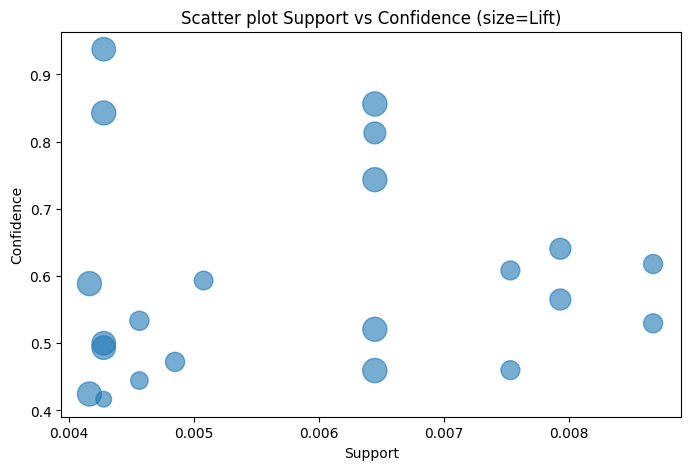

In [ ]:
plt.figure(figsize=(8,5))
plt.scatter(
    rules_ap_sorted['support'],
    rules_ap_sorted['confidence'],
    s=rules_ap_sorted['lift']*5, # size proportional lift
    alpha=0.6
)
plt.xlabel("Support")
plt.ylabel("Confidence")
plt.title("Scatter plot Support vs Confidence (size=Lift)")
plt.show()


#### Trực quan hóa mối quan hệ Support – Confidence của các luật kết hợp

Biểu đồ scatter trên thể hiện các luật kết hợp thu được
từ thuật toán Apriori với các thông số:

- **Trục X (Support)**: tần suất xuất hiện của tập item antecedent và consequent cùng nhau trong dữ liệu.  
  → Support càng cao, luật xuất hiện càng phổ biến.

- **Trục Y (Confidence)**: độ tin cậy của luật, tức xác suất người dùng đọc antecedent sẽ đọc consequent.  
  → Confidence càng cao, luật càng đáng tin cậy.

- **Kích thước điểm (size = Lift × 5)**: Lift đo sức mạnh của luật so với việc hai sách xuất hiện độc lập.  
  → Lift càng lớn, mối liên hệ giữa hai sách càng mạnh và không ngẫu nhiên.

- **Alpha = 0.6**: làm điểm bán trong suốt để nhìn được các điểm chồng nhau.

##### Nhận xét từ biểu đồ:

- Các điểm nằm **gần trục trên bên phải**:
  - Support và Confidence đều cao
  - Là những luật phổ biến và đáng tin cậy, phù hợp để gợi ý sách.
  
- Các điểm **vừa cao Confidence vừa Lift lớn nhưng Support thấp**:
  - Luật mạnh nhưng ít người dùng thực hiện, vẫn có giá trị gợi ý nhưng ít phổ biến.

##### Ý nghĩa trong gợi ý sách:

- Biểu đồ giúp trực quan hóa **toàn bộ luật**, không chỉ Top 10.  
- Cho thấy **luật nào mạnh – phổ biến – đáng tin cậy**, từ đó lựa chọn các sách để gợi ý người dùng hiệu quả.


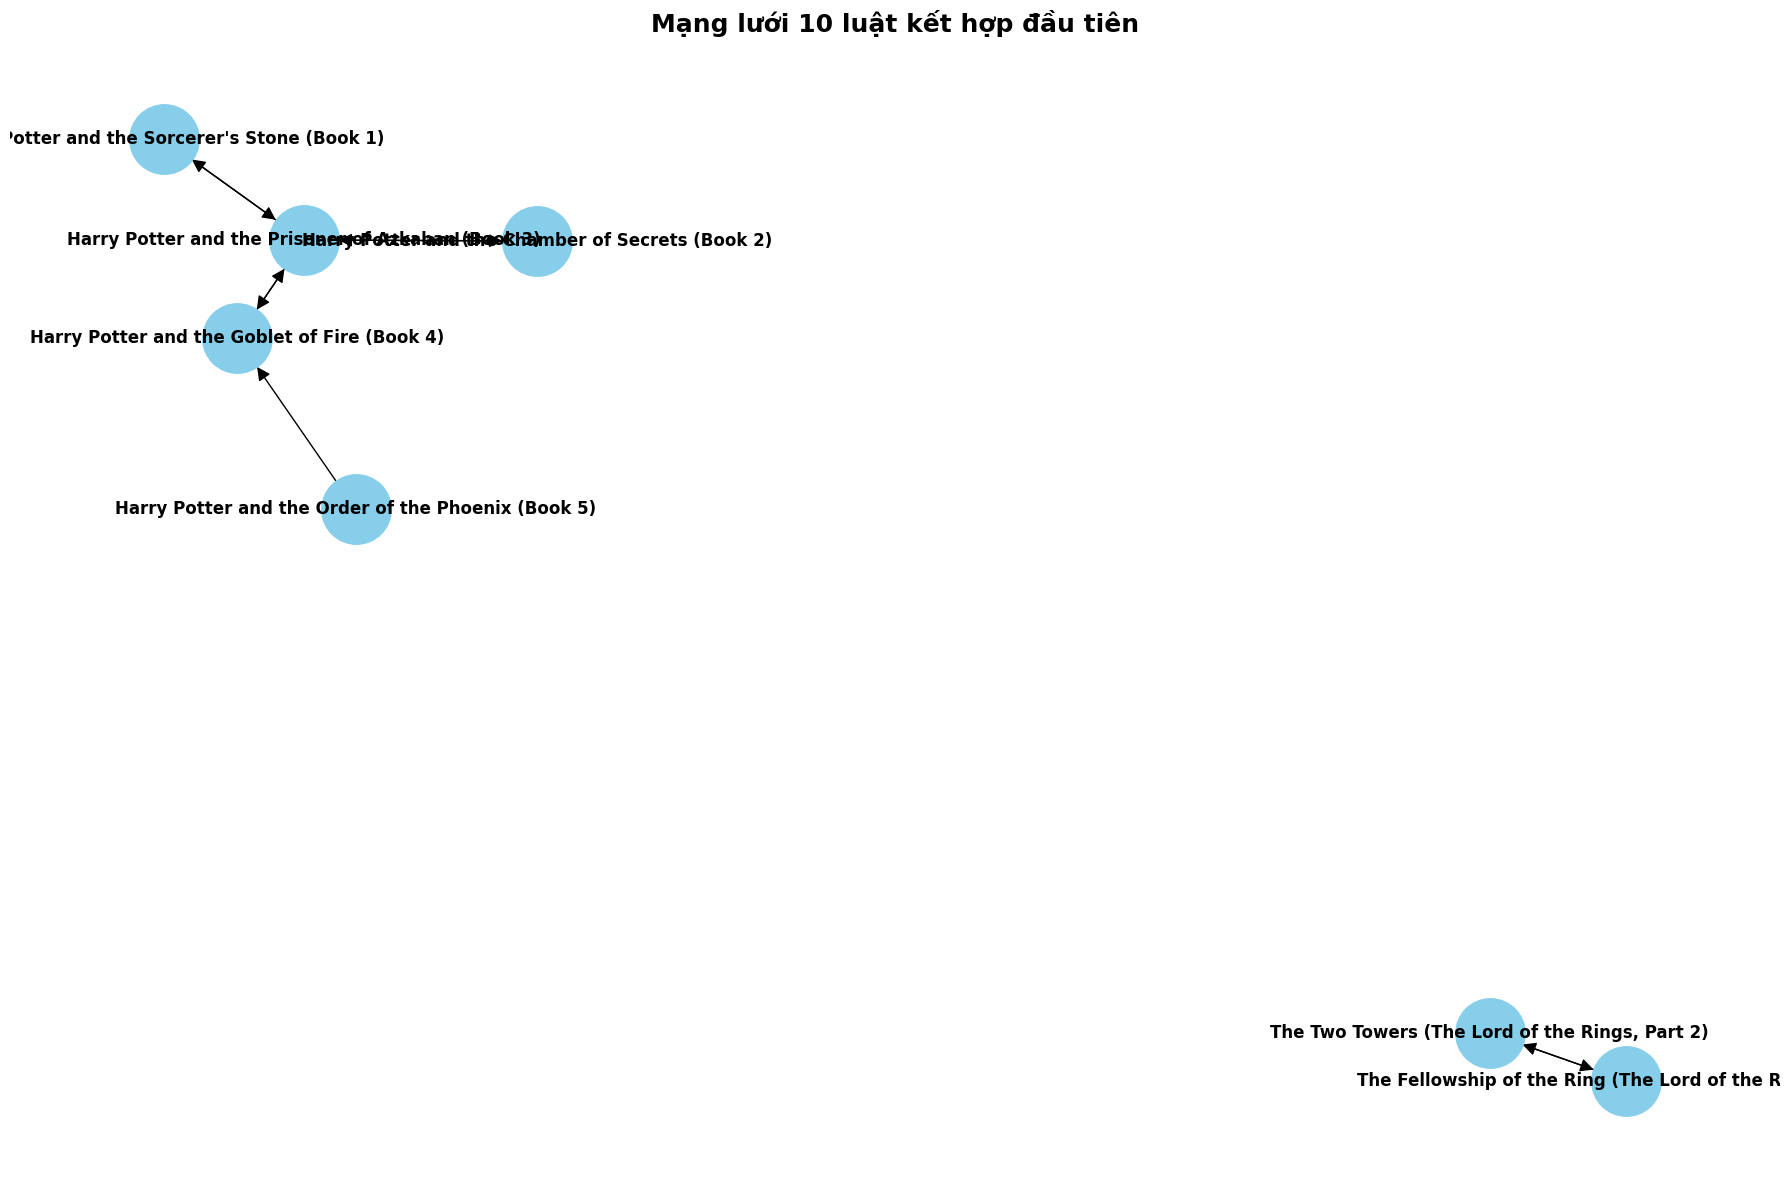

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# Tạo đồ thị có hướng
G = nx.DiGraph()

# Thêm 10 luật kết hợp đầu tiên
for _, row in rules_ap_sorted.head(15).iterrows():
    G.add_edge(
        list(row['antecedents'])[0],
        list(row['consequents'])[0],
        weight=row['lift']  # có thể dùng weight để chỉnh kích thước mũi tên sau
    )

fig, ax = plt.subplots(figsize=(18,12))
nx.draw(G, pos, with_labels=True, node_size=2500, node_color='skyblue', font_size=12, font_weight='bold', arrowsize=20, ax=ax)
plt.title("Mạng lưới 10 luật kết hợp đầu tiên", fontsize=18, fontweight='bold')
plt.tight_layout()
plt.show()


#### Trực quan hóa mạng lưới 10 luật kết hợp đầu tiên

Biểu đồ network graph trên thể hiện **mối quan hệ giữa các sách**
dựa trên 10 luật kết hợp đầu tiên thu được từ thuật toán Apriori.

- **Node (hình tròn)**: đại diện cho từng cuốn sách.  
- **Edge (mũi tên)**: đại diện cho luật kết hợp, từ **antecedent → consequent**.  
  → Nghĩa là nếu người dùng đọc cuốn antecedent, họ có khả năng đọc cuốn consequent.  
- **Chiều dài, vị trí node**: được sắp xếp tự động bằng **spring_layout**, sao cho các node liên quan gần nhau.  
- **Màu sắc node (skyblue) và kích thước node**: giúp dễ phân biệt các sách chính trong luật.  
- **Arrow size và style**: chỉ hướng luật và làm biểu đồ trực quan hơn.  
- **Weight của edge**: tương ứng với Lift của luật, biểu thị **sức mạnh mối quan hệ**.

##### Nhận xét từ mạng lưới:

- Các sách trong cùng **series (Harry Potter)** được kết nối chặt chẽ với nhau.  
- Mối quan hệ giữa các sách **không phải ngẫu nhiên**, phản ánh hành vi đọc theo chuỗi của người dùng.  
- Biểu đồ giúp thấy **mối quan hệ trực quan giữa sách**, dễ dàng chọn ra các luật có thể dùng để gợi ý sách cho người dùng.  

##### Ý nghĩa trong bài toán gợi ý sách:

- Dựa vào network graph, có thể **xác định sách gợi ý** một cách trực quan.  
- Các node trung tâm, có nhiều kết nối, thường là **sách phổ biến hoặc quan trọng trong series**, phù hợp để ưu tiên gợi ý.
